<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/05-modern-training-techniques/03_training_model_with_optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Training model with optimizers

There is an issue with the learning rate $\eta$. We choose one learning rate for every batch of every epoch of training.

So, the first type of improvement is to alter the learning rate $\eta$ as a
function of how far along we are in the optimization process $(t)$.

Right now, the important thing is
to understand that we have created an abstraction for altering the learning rate, and this
abstraction is called a learning rate schedule.

The learning rate $\eta$ simply controls how quickly we follow that information. But the gradient $g^t$ is only as good as the data we use to train the model. If our data is noisy (and it almost
always is), our gradients will also be noisy.

The other two are real problems. Say, for example, that we sometimes get a
gradient $g^t$ that is just too large. 

This can happen when we add hundreds of layers to our
network and is a common problem called an exploding gradient.

The opposite situation occurs too; the gradient could be too small $|| g^t ||_2 \to \infty$, causing us to make no progress toward training
(even with a large $\eta$). 

This is called a vanishing gradient and can occur in almost any
architecture but is particularly common when we use the $tanh(.)$ and $\sigma(.)$ activation functions.

PyTorch provides two interfaces for us to implement the learning rate schedule $L(., .)$ and the gradient $G(.)$ functions.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/05-modern-training-techniques/images/1.png?raw=1' width='600'/>

Let's implement optimizers and schedulers.

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

from sklearn.datasets import make_moons

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from idlmam import train_simple_network, Flatten, weight_reset, set_seed, run_epoch

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(45)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We use the
Fashion-MNIST dataset because it is slightly more challenging while retaining the same
size and shape as the original MNIST corpus, which will let us accomplish some testing
in a reasonable time.

In [ ]:
epochs = 50
B = 256

train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=B)

##Training algorithem

Some problems take just a few epochs, others take hundreds to thousands, and
both of these factors change based on how much data you have. 

For these reasons, I don’t like requiring a learning rate schedule to always be used. I like to work without one first and then add one based on the problem at hand. 

However, we must always use some kind of optimizer. So if none is given, we  use a good default.

In [7]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None, 
                  score_funcs=None, epochs=50, device="cpu", checkpoint_file=None, 
                  lr_schedule=None, optimizer=None, disable_tqdm=False):
  """
  Train simple neural networks
    
  Keyword arguments:
  model -- the PyTorch model / "Module" to train
  loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
  train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
  val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
  test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
  score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
  epochs -- the number of training epochs to perform
  device -- the compute lodation to perform training
  lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
  optimizer -- the method used to alter the gradients for learning
  """
  if score_funcs == None:
    score_funcs = {}

  tracking = ["epoch", "total time", "train loss"]

  if val_loader  is not None:
    tracking.append("val loss")

  if test_loader is not None:
    tracking.append("test loss")
  
  for eval_score in score_funcs:
    tracking.append("train " + eval_score)
    if val_loader is not None:
      tracking.append("val " + eval_score)
    if test_loader is not None:
      tracking.append("test " + eval_score)

  # How long have we spent in the training loop?
  total_train_time = 0
  results = {}
  # Initialize every item with an empty list
  for item in tracking:
    results[item] = []

  if optimizer == None:
    # AdamW optimizer is a good default optimizer
    optimizer = torch.optim.AdamW(model.parameters())

  # Place the model on the correct compute resource (CPU or GPU)
  model.to(device)

  # iterating through all the data (batches) multiple times (epochs)
  for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    # Put the model in training mode
    model = model.train()

    # train the model
    total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
    
    results["total time"].append(total_train_time)
    results["epoch"].append(epoch)

    if val_loader is not None:
      #  Put the model to "evaluation" mode, b/c we don't want to make any updates!
      model = model.eval()
      with torch.no_grad():
        run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")

    # In PyTorch, the convention is to update the learning rate after every epoch
    if lr_schedule is not None:
      if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
        lr_schedule.step(results["val loss"][-1])
      else:
        lr_schedule.step()

    if test_loader is not None:
      model = model.eval()
      with torch.no_grad():
        run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    # lets us save the model, the optimizer state, and other information, all in one object
    if checkpoint_file is not None:
      torch.save({
          "epoch": epoch,
          "model_state_dict": model.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "results": results
      }, checkpoint_file)

  # Finally, convert the results into a pandas DataFrame
  return pd.DataFrame.from_dict(results)

##Training model

We have everything we need to train our model.

In [8]:
D = 28 * 28       # input size
n = 128           # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

In [9]:
fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, classes)
)

Last, we need to settle on a default starting learning rate $\eta_0$. If we do not provide any kind of learning rate schedule $L(., .)$, then $\eta_0$ will be used for every epoch of training.

In [10]:
eta_0 = 0.1 

Notice that we set the default learning rate $\eta_0$ in the optimizer’s
constructor. 

This is the standard process in PyTorch, and any LRSchedule object we
might use will reach into the optimizer object to alter the learning rate.

In [11]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0),
                          checkpoint_file="model.pt",
                          score_funcs={"Acc": accuracy_score},
                          device=device)

Let's quickly plot the training and validation
accuracy.

In [13]:
fc_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,8.047041,1.008232,0.628697,0.642000,0.7756
1,1,13.545834,0.561391,0.618343,0.795767,0.7755
2,2,20.080403,0.493710,0.549053,0.821217,0.7904
3,3,25.596590,0.459425,0.497841,0.832617,0.8199
4,4,31.183548,0.436893,0.444015,0.842467,0.8384


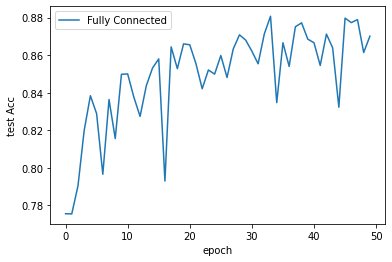

In [14]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Fully Connected")

##Making better use of gradients

Think of $L(., .)$ as setting the
desired speed for the journey. But detours, potholes, and other obstacles in the short
term may require a change in speed. This is why we also want to modify the gradient $g$ with a function $G(.)$.

###SGD with momentum: Adapting to gradient consistency

We want to increase the learning rate if the gradient for parameter $j$ consistently heads
in the same direction. We can describe this as wanting the gradient to build momentum.
If the gradient in one direction keeps returning similar values, it should start taking bigger and bigger steps in the same direction.

In [ ]:
# re-randomize the weights of our model so that we don't need to define it again
fc_model.apply(weight_reset)

# Set up the optimizer
optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0, momentum=0.9, nesterov=False)

# train like normal and pass along the desired optimizer and schedule
fc_results_momentum = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=optimizer,
                          score_funcs={"Accuracy": accuracy_score},
                          device=device)

###Nesterov momentum: Adapting to changing consistency

In Nesterov momentum, we instead decide to be patient. Normal momentum at step
$t$ immediately calculates the new gradient $g^t$ and adds the velocity $v^t$. 

Nesterov first acts on the velocity and `then` calculates a new gradient `after` letting the momentum move
us. 

This way, if we are moving in the `wrong` direction, Nesterov will likely have a larger gradient to push us back in the correct direction sooner.

In [ ]:
# re-randomize the weights of our model so that we don't need to define it again
fc_model.apply(weight_reset)

optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0, momentum=0.9, nesterov=True)

# train like normal and pass along the desired optimizer
fc_results_nestrov = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=optimizer,
                          score_funcs={"Accuracy": accuracy_score},
                          device=device)

###Comparing SGD with momentum

In [18]:
fc_results_momentum.head()

,epoch,total time,train loss,test loss,train Accuracy,test Accuracy
0,0,5.393661,0.648520,0.479447,0.761217,0.8249
1,1,11.106987,0.411441,0.455567,0.848967,0.8292
2,2,16.693768,0.374318,0.387401,0.861150,0.8570
3,3,23.316959,0.350284,0.391006,0.869200,0.8572
4,4,29.389882,0.336461,0.433116,0.875617,0.8437


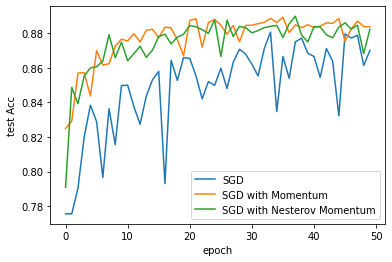

In [19]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="SGD")
sns.lineplot(x="epoch", y="test Accuracy", data=fc_results_momentum, label="SGD with Momentum")
sns.lineplot(x="epoch", y="test Accuracy", data=fc_results_nestrov, label="SGD with Nesterov Momentum")

###Adam: Adding variance to momentum

In [ ]:
# re-randomize the weights of our model so that we don't need to define it again
fc_model.apply(weight_reset)

# Set up the optimizer
optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0)
# pick a schedule and pass the optimizer in
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs//4, gamma=0.3)

# train like normal and pass along the desired optimizer and schedule
fc_results_steplr = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=optimizer,
                          lr_schedule=scheduler,
                          checkpoint_file="model.pt",
                          score_funcs={"Accuracy": accuracy_score},
                          device=device)

###Cosine annealing: Greater accuracy but less stability

Cosine annealing has a
different logic and strategy than exponential decay and the step learning rate. The
latter two only decrease the learning rate, but cosine annealing decreases and increases
the learning rate. 

This approach is very effective for getting the best possible results
but does not provide the same degree of stabilization, so it might not work on poorly
behaved datasets and networks.

Text(0, 0.5, 'Learning Rate')

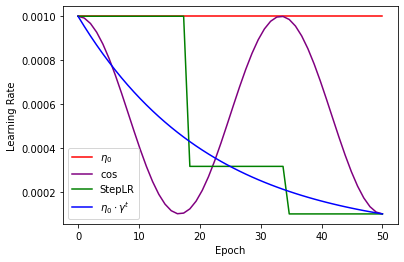

In [ ]:
# Computes the cosine schedule
cos_lr = eta_min + 0.5 * (eta_init - eta_min) * (1 + np.cos(epochs_input / (T/3.0) * np.pi))

sns.lineplot(x=epochs_input, y=eta_init, color="red", label="$\eta_0$")
sns.lineplot(x=epochs_input, y=cos_lr, color="purple", label="$\cos$")
sns.lineplot(x=epochs_input, y=[eta_init] * 18 + [eta_init / 3.16] * 16 + [eta_init / 10] * 16, color="green", label="StepLR")
ax = sns.lineplot(x=epochs_input, y=effective_learning_rate, color="blue", label="$\eta_0 \cdot \gamma^t$")
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")

Why would we want to fluctuate the learning rate up and down?

It makes more sense when we remember that neural
networks are not convex. A convex function has only one local minimum, and every
gradient leads us to the optimal solution. But neural networks are non-convex and can
have many local minima, which may not be a good solution. If our model first heads
towards one of these local minima, and we decrease only the learning rate, we may get
stuck in this sub-optimal area.

In [ ]:
# re-randomize the weights of our model so that we don't need to define it again
fc_model.apply(weight_reset)

# Set up the optimizer
optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0)
# Telling the cosine to go down/up/down (thats 3), if we were doing more than 10 epochs I would push this higher 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.0001)

# train like normal and pass along the desired optimizer and schedule
fc_results_coslr = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=optimizer,
                          lr_schedule=scheduler,
                          checkpoint_file="model.pt",
                          score_funcs={"Accuracy": accuracy_score},
                          device=device)

###Validation plateau: Data-based adjustments

None of the learning rate schedules use information about how well the learning is going.

But what information do we have available to use, and how should we use it?

The primary information we have is the loss ` for each epoch of training, and we can add it into
our approach to try to maximize the accuracy of our final model. 

This is what the
plateau-based strategy does, and it will often get you the best possible accuracy for your
final model.

Let’s look at the training and testing set loss from the baseline network.

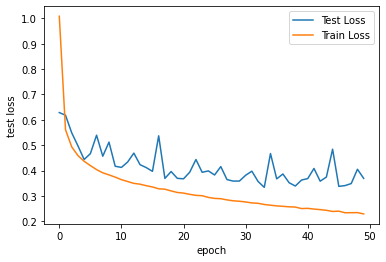

In [ ]:
sns.lineplot(x="epoch", y="test loss", data=fc_results, label="Test Loss")
sns.lineplot(x="epoch", y="train loss", data=fc_results, label="Train Loss")

We expect the training loss to always go down, so it isn’t a good source of information
about how well the learning is going.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/05-modern-training-techniques/images/4.png?raw=1' width='600'/>

In [ ]:
# re-randomize the weights of our model so that we don't need to define it again
fc_model.apply(weight_reset)

# create a training and validation sub-set, since we do not have an explicit validation and test set
train_sub_set, val_sub_set = torch.utils.data.random_split(train_data, [int(len(train_data) * 0.8), int(len(train_data) * 0.2)])

# create loaders for the train and validation sub-sets
train_sub_loader = DataLoader(train_sub_set, batch_size=B, shuffle=True)
val_sub_loader = DataLoader(val_sub_set, batch_size=B, shuffle=False)
##our test loader stays the same, never alter or peek on your test data!

# Set up the optimizer
optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0)
# Telling the cosine to go down/up/down (thats 3), if we were doing more than 10 epochs I would push this higher 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=10)

# train like normal and pass along the desired optimizer and schedule
fc_results_plateau = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          val_loader=val_sub_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=optimizer,
                          lr_schedule=scheduler,
                          checkpoint_file="model.pt",
                          score_funcs={"Accuracy": accuracy_score},
                          device=device)

Plateau-based adjustments to the learning rate are a very popular and successful strategy.

But you should not blindly use it in all circumstances.
There are two particular cases where ReduceLROnPlateau may perform
poorly or even mislead you into an overconfident result.

* First is the case where you don’t have much data.
* The second case is when your data strongly violates the identically and independently distributed (IID) assumption.

###Comparing the schedules

Now that we have trained four common learning rate schedules, we can compare their
results and see which performed best.

In [ ]:
fc_results_expolr.head()

,epoch,total time,train loss,test loss,train Accuracy,test Accuracy
0,0,5.616214,1.009418,0.628053,0.648000,0.7715
1,1,11.166653,0.552689,0.529438,0.798450,0.8075
2,2,16.711314,0.479615,0.476072,0.826617,0.8270
3,3,22.280765,0.449449,0.489149,0.837450,0.8186
4,4,27.779186,0.426249,0.486698,0.846600,0.8233


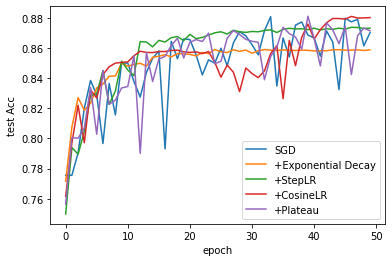

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="SGD")
sns.lineplot(x="epoch", y="test Accuracy", data=fc_results_expolr, label="+Exponential Decay")
sns.lineplot(x="epoch", y="test Accuracy", data=fc_results_steplr, label="+StepLR")
sns.lineplot(x="epoch", y="test Accuracy", data=fc_results_coslr, label="+CosineLR")
sns.lineplot(x="epoch", y="test Accuracy", data=fc_results_plateau, label="+Plateau")

Let's summarizes the pros and cons and when you might want to use each
method.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/05-modern-training-techniques/images/4.png?raw=1' width='600'/>